In [1]:
# ==========================================
# GLOBAL CONFIGURATION
# ==========================================

# Change this path whenever you have a new sample
FILE_ID = "13_1"  
IMAGE_PATH = f"/home/fetalusr1/Fetal-Head-Segmentation-master/IMG_20250329_13_1.nii"

# This automatically names your outputs based on the input
MASK_OUTPUT_PATH = f"./FilteredRes/segmentation_result_{FILE_ID}_interpolated.nii.gz"
REPORT_ZIP_NAME = f"3D_Full_Report_{FILE_ID}.zip"

print(f"🚀 Ready to process: {IMAGE_PATH}")
print(f"💾 Results will save to: {MASK_OUTPUT_PATH}")

🚀 Ready to process: /home/fetalusr1/Fetal-Head-Segmentation-master/IMG_20250329_13_1.nii
💾 Results will save to: ./FilteredRes/segmentation_result_13_1_interpolated.nii.gz


In [2]:
import os
# optimizing memory allocation to reduce fragmentation
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"
print("✅ Memory fragmentation rules applied.")

✅ Memory fragmentation rules applied.


In [3]:
import os
import torch

# 1. Help PyTorch manage fragmented memory
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"

# 2. Clear any lingering cache
torch.cuda.empty_cache()

print(f"✅ Memory settings applied. Free memory: {torch.cuda.mem_get_info()[0] / 1024**3:.2f} GB")

/home/fetalusr1/miniconda3/envs/fetal_project/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Memory settings applied. Free memory: 45.71 GB


In [4]:
import os
import sys

# Get the path to your current environment
conda_prefix = sys.prefix
lib_path = os.path.join(conda_prefix, 'lib')

# Force this path to the front of the line
os.environ['LD_LIBRARY_PATH'] = f"{lib_path}:{os.environ.get('LD_LIBRARY_PATH', '')}"

print(f"✅ Forced Library Path: {lib_path}")

✅ Forced Library Path: /home/fetalusr1/miniconda3/envs/fetal_project/lib


In [5]:
import torch

try:
    # Try a simple calculation on the GPU
    x = torch.tensor([1.0, 2.0]).cuda()
    y = torch.tensor([3.0, 4.0]).cuda()
    z = x * y
    print("--------------------------------------------------")
    print(f"🎉 SUCCESS: GPU Math works! Result: {z.cpu().numpy()}")
    print("--------------------------------------------------")
except RuntimeError as e:
    print("--------------------------------------------------")
    print(f"❌ FAILURE: {e}")
    print("--------------------------------------------------")

--------------------------------------------------
🎉 SUCCESS: GPU Math works! Result: [3. 8.]
--------------------------------------------------


In [6]:
!nvidia-smi


/bin/bash: /home/fetalusr1/miniconda3/envs/fetal_project/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Thu Jan 22 09:18:35 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A6000               On  |   00000000:04:00.0 Off |                  Off |
| 30%   35C    P2             72W /  300W |    1733MiB /  49140MiB |      0%      Default |
|      

In [7]:
from PIL import Image
import torch
import numpy as np
from modeling.BaseModel import BaseModel
from modeling import build_model
from utilities.distributed import init_distributed
from utilities.arguments import load_opt_from_config_files
from utilities.constants import BIOMED_CLASSES
import matplotlib.pyplot as plt
from inference_utils.inference import interactive_infer_image
from inference_utils.output_processing import check_mask_stats
from inference_utils.processing_utils import process_intensity_image
from inference_utils.processing_utils import read_nifti
import nibabel as nib
import pandas as pd
import SimpleITK as sitk
from skimage.measure import regionprops, label
from skimage.transform import resize


out_probs = []
predicted_masks = []

Authorization required, but no authorization protocol specified

Authorization required, but no authorization protocol specified



Deformable Transformer Encoder is not available.


/home/fetalusr1/miniconda3/envs/fetal_project/lib/python3.8/site-packages/torchvision/transforms/transforms.py:287: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


## Loading the Finetuned BiomedParse model

In [8]:
# Build model config
opt = load_opt_from_config_files(["configs/biomedparse_inference.yaml"])
opt = init_distributed(opt)

# Load model from pretrained weights
finetuned_pth = '/home/fetalusr1/Fetal-Head-Segmentation-master/model_state_dict.pt' # Replace with the path to your finetuned checkpoint

model = BaseModel(opt, build_model(opt)).from_pretrained(pretrained=finetuned_pth).eval().cuda()

with torch.no_grad():
    model.model.sem_seg_head.predictor.lang_encoder.get_text_embeddings(BIOMED_CLASSES + ["background"], is_eval=True)

$UNUSED$ criterion.empty_weight, Ckpt Shape: torch.Size([17])


## Utilities

In [9]:
def get_segmentation_masks(original_image, segmentation_masks, texts, rotate=0):
    ''' Plot a list of segmentation mask over an image showing only the segmented region.
    '''
    original_image = original_image[:, :, :3]

    segmented_images = []

    for i, mask in enumerate(segmentation_masks):
        segmented_image = original_image.copy()
        segmented_image[mask <= 0.5] = [0, 0, 0]
        segmented_images.append(segmented_image)
        
    return segmented_images

In [10]:
def inference_nifti(file_path, text_prompts, is_CT, slice_idx, site=None, HW_index=(0, 1), channel_idx=None, rotate=0):

    image = read_nifti(file_path, is_CT, slice_idx, site=site, HW_index=HW_index, channel_idx=channel_idx)
    
    pred_mask,out_prob = interactive_infer_image(model, Image.fromarray(image), text_prompts)
    predicted_masks.append(pred_mask)
    segmented_images = get_segmentation_masks(image, pred_mask, text_prompts, rotate=rotate)
    out_probs.append(out_prob)
    
    return image, pred_mask, segmented_images

### Post-processing Utility

In [11]:
def process_predicted_volume(volume_data, threshold_factor=0.35, output_prefix='processed'):
    """
    Process the predicted volume to filter based on ellipse measurements.
    """
    data = volume_data
    print(f"Processing volume with shape: {data.shape}")
    
    # Calculate measurements for all slices
    results = []
    z_0 = data.shape[2] // 2  # Reference slice (middle slice)
    
    print(f"Reference slice: {z_0}")
    
    for i in range(data.shape[2]):
        slice_data = data[:, :, i]
        
        # Skip empty slices
        if np.sum(slice_data) == 0:
            continue
            
        # Binarize the slice
        slice_bin = np.where(slice_data > 0, 1, 0).astype(np.uint8)
        
        # Fill holes
        slice_bin_filled = sitk.BinaryFillhole(sitk.GetImageFromArray(slice_bin))
        slice_bin_filled = sitk.GetArrayFromImage(slice_bin_filled)
        
        # Get region properties
        labeled_image = label(slice_bin_filled)
        props = regionprops(labeled_image)
        
        for prop in props:
            results.append({
                'slice_index': i,
                'major_axis_length': prop.major_axis_length,
                'minor_axis_length': prop.minor_axis_length,
                'centroid_x': prop.centroid[1],
                'centroid_y': prop.centroid[0],
                'orientation': prop.orientation,
                'area': prop.area
            })
    
    # Create DataFrame
    df_results = pd.DataFrame(results)
    print(f"Found {len(results)} regions across {len(df_results['slice_index'].unique())} slices")
    
    # Get reference slice measurements for filtering
    standard_slice_data = df_results[df_results['slice_index'] == z_0]
    
    if standard_slice_data.empty:
        print(f"Warning: No data found in reference slice {z_0}")
        # Use overall median as fallback
        major_axis_length_std = df_results['major_axis_length'].median()
        minor_axis_length_std = df_results['minor_axis_length'].median()
        centroid_x_std = df_results['centroid_x'].median()
        centroid_y_std = df_results['centroid_y'].median()
    else:
        major_axis_length_std = standard_slice_data['major_axis_length'].values[0]
        minor_axis_length_std = standard_slice_data['minor_axis_length'].values[0]
        centroid_x_std = standard_slice_data['centroid_x'].values[0]
        centroid_y_std = standard_slice_data['centroid_y'].values[0]
    
    # Define thresholds
    major_axis_length_threshold = major_axis_length_std * (1 - threshold_factor)
    minor_axis_length_threshold = minor_axis_length_std * (1 - threshold_factor)
    
    print(f"Reference measurements - Major: {major_axis_length_std:.2f}, Minor: {minor_axis_length_std:.2f}")
    print(f"Filtering thresholds - Major: {major_axis_length_threshold:.2f}, Minor: {minor_axis_length_threshold:.2f}")
    
    # Filter based on thresholds
    filtered_df = df_results[
        (df_results['major_axis_length'] >= major_axis_length_threshold) &
        (df_results['minor_axis_length'] >= minor_axis_length_threshold)
    ]
    
    print(f"After filtering: {len(filtered_df)} regions in {len(filtered_df['slice_index'].unique())} slices")
    
    # In filtered_df, in case of repeated slices, keep the one with maximum major axis length
    filtered_df = filtered_df.loc[filtered_df.groupby('slice_index')['major_axis_length'].idxmax()]
    
    # Create filtered volume
    filtered_slices = filtered_df['slice_index'].unique()
    filtered_volume = np.zeros_like(data)
    
    for slice_idx in range(data.shape[2]):
        if slice_idx in filtered_slices:
            filtered_volume[:, :, slice_idx] = data[:, :, slice_idx]
    
    return filtered_volume, filtered_df

### Interpolation Utility

In [12]:
def interpolate_blank_slices(image_path, processed_volume, blank_slices, predicted_masks, delta=1):
    """
    Interpolate blank slices in the processed volume using the previous slice.
    """
    vol_data = nib.load(image_path).get_fdata()
    central_slice = vol_data.shape[2] // 2
    
    for slice_idx in blank_slices:
        # Ensure we have a valid previous slice
        prev_slice_idx = slice_idx - delta
        if prev_slice_idx < 0 or prev_slice_idx >= len(predicted_masks):
            continue
            
        # Get the previous mask
        prev_mask = predicted_masks[prev_slice_idx][0]  # Get first mask from the list
        
        #update predicted_masks
        predicted_masks[slice_idx] = [prev_mask.copy()]  # Store the previous mask
        # Ensure the previous mask is not empty
        if np.sum(prev_mask) == 0:
            print(f"Warning: Previous mask for slice {prev_slice_idx} is empty. Skipping interpolation for slice {slice_idx}.")
            continue
        # Scale the mask based on position relative to center
        if slice_idx < central_slice: 
            # Increase the mask size by 0.5%
            new_mask = prev_mask * 1.005
        else:
            # Decrease the mask size by 0.5%
            new_mask = prev_mask * 0.995
        
        # Read the original image for this slice
        image = read_nifti(image_path, is_CT=False, slice_idx=slice_idx, site=None, HW_index=(0, 1), channel_idx=None)
        
        # Get the segmented image
        new_segmented_image = get_segmentation_masks(image, [new_mask], ['fetal head'], rotate=0)[0]
        
        # Convert RGB segmentation to grayscale if needed
        if len(new_segmented_image.shape) == 3:
            gray_mask = np.mean(new_segmented_image, axis=2)
        else:
            gray_mask = new_segmented_image
        
        # Resize to match volume dimensions and store
        from skimage.transform import resize
        processed_volume[:, :, slice_idx] = resize(gray_mask, (vol_data.shape[0], vol_data.shape[1]), preserve_range=True)
    
    return processed_volume

## Working

In [38]:
image_path = '/home/fetalusr1/Fetal-Head-Segmentation-master/IMG_20250329_13_1.nii'
text_prompt = ['fetal head']
vol = nib.load(image_path)
vol_data = vol.get_fdata()
vol_data.shape

(227, 149, 234)

In [14]:
# Initialize volume to store all prediction masks
pred_volume = np.zeros((vol_data.shape[0], vol_data.shape[1], vol_data.shape[2]))

counter = 0
for slice_idx in range(vol_data.shape[2]):
    image, pred_mask, segmentation_mask = inference_nifti(image_path, text_prompt, is_CT=False, slice_idx=slice_idx, site=None, rotate=0)
    
    # Convert RGB segmentation mask to grayscale
    if len(segmentation_mask[0].shape) == 3:
        # Convert to grayscale by taking the mean across color channels
        gray_mask = np.mean(segmentation_mask[0], axis=2)
    else:
        gray_mask = segmentation_mask[0]
    
    # Store the prediction mask in the volume
    pred_volume[:, :, slice_idx] = resize(gray_mask, (vol_data.shape[0], vol_data.shape[1]), preserve_range=True)

# Post processing

processed_volume, filtered_measurements = process_predicted_volume(
    pred_volume, 
    threshold_factor=0.4,  # Adjust as needed
    output_prefix='3_2'
)

print(f"Original volume had {np.sum(pred_volume > 0)} non-zero voxels")
print(f"Processed volume has {np.sum(processed_volume > 0)} non-zero voxels")

/home/fetalusr1/miniconda3/envs/fetal_project/lib/python3.8/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/home/fetalusr1/Fetal-Head-Segmentation-master/modeling/modules/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mo

Processing volume with shape: (227, 149, 234)
Reference slice: 117
Found 260 regions across 234 slices
Reference measurements - Major: 168.25, Minor: 95.13
Filtering thresholds - Major: 100.95, Minor: 57.08
After filtering: 109 regions in 109 slices
Original volume had 1379858 non-zero voxels
Processed volume has 1131293 non-zero voxels


In [15]:
#Get the first slice that survived filtering
first_filtered_slice = min(filtered_measurements['slice_index'].unique())
last_filtered_slice = max(filtered_measurements['slice_index'].unique())
print(f"First filtered slice: {first_filtered_slice}")
print(f"Last filtered slice: {last_filtered_slice}")
#from the filtered slice to the center slice, get all the slices which are blank
blank_slices = []
for slice_idx in range(first_filtered_slice, last_filtered_slice + 1):
    if np.sum(processed_volume[:, :, slice_idx]) == 0:
        blank_slices.append(slice_idx)
# Print the blank slices
print(f"Blank slices from {first_filtered_slice} to {vol_data.shape[2]-1}: {blank_slices}")

First filtered slice: 72
Last filtered slice: 228
Blank slices from 72 to 233: [144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227]


In [16]:
import os

# Create results directories if they don't exist
os.makedirs('./results', exist_ok=True)
os.makedirs('./FilteredRes', exist_ok=True)

# Load original NIfTI for header info
original_nii = nib.load(image_path)

# Save raw prediction
pred_nii = nib.Nifti1Image(pred_volume, original_nii.affine, original_nii.header)
raw_filename = f'./results/segmentation_RAW.nii.gz'
nib.save(pred_nii, raw_filename)
print(f"Raw prediction saved to {raw_filename}")

# Save processed prediction
processed_nii = nib.Nifti1Image(processed_volume, original_nii.affine, original_nii.header)
processed_filename = f'./FilteredRes/segmentation_fil.nii.gz'
nib.save(processed_nii, processed_filename)
print(f"Processed prediction saved to {processed_filename}")

interpolated_volume = interpolate_blank_slices(image_path, processed_volume, blank_slices, predicted_masks, delta=1)
# Save interpolated prediction
interpolated_nii = nib.Nifti1Image(interpolated_volume, original_nii.affine, original_nii.header)
interpolated_filename = f'./FilteredRes/segmentation_inter.nii.gz'
nib.save(interpolated_nii, interpolated_filename)
print(f"Interpolated prediction saved to {interpolated_filename}")

Raw prediction saved to ./results/segmentation_RAW.nii.gz
Processed prediction saved to ./FilteredRes/segmentation_fil.nii.gz
Interpolated prediction saved to ./FilteredRes/segmentation_inter.nii.gz


In [17]:
import nibabel as nib
import numpy as np

# 1. Check the physical data shape
print(f"📊 Volume Array Shape: {processed_volume.shape}")
print(f"📊 Volume Data Type: {processed_volume.dtype}")
print(f"📊 Max Value in Volume: {np.max(processed_volume)}")

# 2. Check the "Ruler" (Header)
orig_nii = nib.load(image_path)
print(f"📏 Original Zooms (Spacing): {orig_nii.header.get_zooms()}")
print(f"🗺️ Original Affine Matrix:\n{orig_nii.affine}")

# 3. Check for the "Veto" impact
active_slices = np.where(np.sum(processed_volume, axis=(0, 1)) > 0)[0]
print(f"🧩 Number of slices containing data: {len(active_slices)}")

📊 Volume Array Shape: (227, 149, 234)
📊 Volume Data Type: float64
📊 Max Value in Volume: 254.68303701335242
📏 Original Zooms (Spacing): (0.3, 0.3, 0.3)
🗺️ Original Affine Matrix:
[[ 0.30000001  0.         -0.         -0.        ]
 [ 0.          0.30000001 -0.         -0.        ]
 [ 0.          0.          0.30000001  0.        ]
 [ 0.          0.          0.          1.        ]]
🧩 Number of slices containing data: 157


In [18]:
import nibabel as nib
import numpy as np

# 1. Load Original for Reference
orig_nii = nib.load(image_path)

# 2. Check if we need to transpose the axes
# If your data was processed as (H, W, Slices) but needs to be (Slices, H, W)
# we force it into the correct 3D orientation
final_data = processed_volume.astype(np.float32)

# 3. Create the NIfTI object with the CORRECT Affine
# This 'orig_nii.affine' is the key to stopping the rectangle
corrected_nii = nib.Nifti1Image(final_data, orig_nii.affine, orig_nii.header)

# 4. Force the zooms to 0.3mm to stop the 'Squish'
corrected_nii.header.set_zooms((0.3, 0.3, 0.3))

# 5. Save with a unique name
final_path = f'./FilteredRes/final_3D_reconstruction_{FILE_ID}.nii.gz'
nib.save(corrected_nii, final_path)

print(f"✅ Axis Sync Complete.")
print(f"🧩 Data Slices: {len(active_slices)}/234")
print(f"📁 Open this file in Freeview: {final_path}")

✅ Axis Sync Complete.
🧩 Data Slices: 157/234
📁 Open this file in Freeview: ./FilteredRes/final_3D_reconstruction_13_1.nii.gz


In [19]:
import scipy.ndimage as ndimage

# 1. Expand the mask slightly (Dilation)
# This adds a 2-3 pixel buffer around the head so we don't cut into the skull
print("🛡️ Expanding mask buffer...")
structure = ndimage.generate_binary_structure(3, 1)
# dilate by 2 iterations to ensure outer skull is included
expanded_mask = ndimage.binary_dilation(interpolated_volume > 0, structure=structure, iterations=2)

# 2. Smooth the expanded mask (to keep it natural, not jagged)
expanded_mask = ndimage.median_filter(expanded_mask.astype(np.float32), size=3)

# 3. Multiply by Original Intensity
# Now we use the expanded mask so we don't strip too much
final_output_vol = vol_data * expanded_mask

# 4. Save with Header Correction (Fixing the Squished look)
original_zooms = original_nii.header.get_zooms()
improved_nii = nib.Nifti1Image(final_output_vol, original_nii.affine, original_nii.header)
improved_nii.header.set_zooms(original_zooms)

improved_filename = f'./FilteredRes/{FILE_ID}_PRESERVED.nii.gz'
nib.save(improved_nii, improved_filename)
print(f"✅ Anatomically Preserved Result Saved: {improved_filename}")

🛡️ Expanding mask buffer...
✅ Anatomically Preserved Result Saved: ./FilteredRes/13_1_PRESERVED.nii.gz


In [20]:
import nibabel as nib
import numpy as np

# Load original metadata
orig_nii = nib.load(IMAGE_PATH)

# Use your raw prediction volume directly
# We convert to float32 to ensure compatibility with NIfTI
data_to_save = pred_volume.astype(np.float32)

# This is the most conservative way to save:
# Use the EXACT affine and header from the original file
basic_nii = nib.Nifti1Image(data_to_save, orig_nii.affine, orig_nii.header)

# Force the spacing one last time to be sure
basic_nii.header.set_zooms(orig_nii.header.get_zooms())

save_path = './FilteredRes/VERIFY_BASIC_3D.nii.gz'
nib.save(basic_nii, save_path)

print(f"📊 Array Shape saved: {data_to_save.shape}")
print(f"📏 Spacing saved: {basic_nii.header.get_zooms()}")
print(f"✅ Check this in Freeview: {save_path}")

📊 Array Shape saved: (227, 149, 234)
📏 Spacing saved: (0.3, 0.3, 0.3)
✅ Check this in Freeview: ./FilteredRes/VERIFY_BASIC_3D.nii.gz


In [21]:
import scipy.ndimage as ndimage
import nibabel as nib
import numpy as np

# 1. IDENTIFY VETOED SLICES
# Uses your out_probs to find where the AI was too conservative
vetoed_slices = [i for i, score in enumerate(out_probs) if (score[0].item() if hasattr(score[0], 'item') else score[0]) < 0]

# 2. INTERPOLATION (Already in your notebook, but let's ensure it's filled)
# We use a copy to protect your original pred_volume
print(f"🌉 Filling {len(vetoed_slices)} anatomical gaps...")
filled_volume = interpolate_blank_slices(IMAGE_PATH, pred_volume.copy(), vetoed_slices, predicted_masks, delta=1)

# 3. AGGRESSIVE DILATION (The Fix for the Distance to Skull)
# We increase iterations to 3 to "puff out" the mask until it touches the skull bone
print("🛡️ Expanding anatomical buffer to reach skull rim...")
structure = ndimage.generate_binary_structure(3, 1)
# Iterations=3 expands the mask further than your previous code
final_mask = ndimage.binary_dilation(filled_volume > 0, structure=structure, iterations=3)
final_mask = ndimage.median_filter(final_mask.astype(np.float32), size=3)

# 4. INTENSITY RECONSTRUCTION
# This maps the brain texture back onto the expanded mask
final_output_vol = vol_data * final_mask

# 5. SAFE HEADER SYNC (The "Full Head" Fix)
# We use the EXACT same logic you confirmed works in your last block
original_nii = nib.load(IMAGE_PATH)
final_nii = nib.Nifti1Image(final_output_vol.astype(np.float32), original_nii.affine, original_nii.header)
final_nii.header.set_zooms(original_nii.header.get_zooms())

save_path = f'./FilteredRes/FINAL_SUCCESS_{FILE_ID}.nii.gz'
nib.save(final_nii, save_path)

print(f"✅ COMPLETE: Gap to skull closed. Full 3D head saved at: {save_path}")

🌉 Filling 234 anatomical gaps...
🛡️ Expanding anatomical buffer to reach skull rim...
✅ COMPLETE: Gap to skull closed. Full 3D head saved at: ./FilteredRes/FINAL_SUCCESS_13_1.nii.gz


In [37]:
original_nii.header

In [22]:
import scipy.ndimage as ndimage
# This takes your working 'pred_volume' and expands it by 3 pixels in 3D
structure = ndimage.generate_binary_structure(3, 1)
# INCREASE THIS NUMBER TO CLOSE THE SKULL GAP
final_mask = ndimage.binary_dilation(pred_volume > 0, structure=structure, iterations=3)

# Save using the EXACT logic you confirmed works
final_output = vol_data * final_mask.astype(np.float32)
original_nii = nib.load(IMAGE_PATH)
success_nii = nib.Nifti1Image(final_output, original_nii.affine, original_nii.header)
success_nii.header.set_zooms(original_nii.header.get_zooms())

nib.save(success_nii, './FilteredRes/FINAL_SKULL_TOUCH.nii.gz')
print("✅ Saved. This uses your 'Full Head' logic with 3-pixel dilation.")

✅ Saved. This uses your 'Full Head' logic with 3-pixel dilation.


In [23]:
import scipy.ndimage as ndimage
import nibabel as nib
import numpy as np

# 1. CREATE MASK FROM EXISTING WORKING VOLUME
# We start with 'interpolated_volume' which you confirmed is correct/working in memory.
# Any pixel with data becomes part of the mask.
current_mask = interpolated_volume > 0

# 2. CONSERVATIVE DILATION (The Skull Fix)
# Iterations=2: Expands the mask just enough to touch the inner skull without overshooting.
print("🛡️ Applying conservative dilation (2 iterations)...")
structure = ndimage.generate_binary_structure(3, 1)
dilated_mask = ndimage.binary_dilation(current_mask, structure=structure, iterations=2)

# Optional: Slight smoothing to keep edges organic
dilated_mask = ndimage.median_filter(dilated_mask.astype(np.float32), size=3)

# 3. APPLY TO ORIGINAL TEXTURE
# Use the dilated mask to grab the brain + skull edge from the original data
final_output = vol_data * dilated_mask

# 4. SAVE USING NOTEBOOK LOGIC (No 'set_zooms' override)
# We use the exact header/affine from 'original_nii' just like your working Cell 96.
final_nii = nib.Nifti1Image(final_output.astype(np.float32), original_nii.affine, original_nii.header)

save_path = f'./FilteredRes/FINAL_CONSERVATIVE_{FILE_ID}.nii.gz'
nib.save(final_nii, save_path)
print(f"✅ Success. Saved with conservative dilation to: {save_path}")

🛡️ Applying conservative dilation (2 iterations)...
✅ Success. Saved with conservative dilation to: ./FilteredRes/FINAL_CONSERVATIVE_13_1.nii.gz


In [24]:
import scipy.ndimage as ndimage
import nibabel as nib
import numpy as np

# 1. CREATE MASK FROM EXISTING WORKING VOLUME
# We start with 'interpolated_volume' which you confirmed is correct/working in memory.
# Any pixel with data becomes part of the mask.
current_mask = interpolated_volume > 0

# 2. CONSERVATIVE DILATION (The Skull Fix)
# Iterations=2: Expands the mask just enough to touch the inner skull without overshooting.
print("🛡️ Applying conservative dilation (2 iterations)...")
structure = ndimage.generate_binary_structure(3, 1)
dilated_mask = ndimage.binary_dilation(current_mask, structure=structure, iterations=3)

# Optional: Slight smoothing to keep edges organic
dilated_mask = ndimage.median_filter(dilated_mask.astype(np.float32), size=3)

# 3. APPLY TO ORIGINAL TEXTURE
# Use the dilated mask to grab the brain + skull edge from the original data
final_output = vol_data * dilated_mask

# 4. SAVE USING NOTEBOOK LOGIC (No 'set_zooms' override)
# We use the exact header/affine from 'original_nii' just like your working Cell 96.
final_nii = nib.Nifti1Image(final_output.astype(np.float32), original_nii.affine, original_nii.header)

save_path = f'./FilteredRes/FINAL_2ndTIVE_{FILE_ID}.nii.gz'
nib.save(final_nii, save_path)
print(f"✅ Success. Saved with conservative dilation to: {save_path}")

🛡️ Applying conservative dilation (2 iterations)...
✅ Success. Saved with conservative dilation to: ./FilteredRes/FINAL_2ndTIVE_13_1.nii.gz


In [25]:
import scipy.ndimage as ndimage
import nibabel as nib
import numpy as np

# 1. CREATE MASK FROM EXISTING WORKING VOLUME
# We start with 'interpolated_volume' which you confirmed is correct/working in memory.
# Any pixel with data becomes part of the mask.
current_mask = interpolated_volume > 0

# 2. CONSERVATIVE DILATION (The Skull Fix)
# Iterations=2: Expands the mask just enough to touch the inner skull without overshooting.
print("🛡️ Applying conservative dilation (2 iterations)...")
structure = ndimage.generate_binary_structure(3, 1)
dilated_mask = ndimage.binary_dilation(current_mask, structure=structure, iterations=6)

# Optional: Slight smoothing to keep edges organic
dilated_mask = ndimage.median_filter(dilated_mask.astype(np.float32), size=3)

# 3. APPLY TO ORIGINAL TEXTURE
# Use the dilated mask to grab the brain + skull edge from the original data
final_output = vol_data * dilated_mask

# 4. SAVE USING NOTEBOOK LOGIC (No 'set_zooms' override)
# We use the exact header/affine from 'original_nii' just like your working Cell 96.
final_nii = nib.Nifti1Image(final_output.astype(np.float32), original_nii.affine, original_nii.header)

save_path = f'./FilteredRes/6_{FILE_ID}.nii.gz'
nib.save(final_nii, save_path)
print(f"✅ Success. Saved with conservative dilation to: {save_path}")

🛡️ Applying conservative dilation (2 iterations)...
✅ Success. Saved with conservative dilation to: ./FilteredRes/6_13_1.nii.gz


In [26]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation

def calculate_boundary_metrics(image_slice, mask_template):
    """
    Measures the intensity and gradient strength at the boundary of the mask.
    """
    # 1. Define the "Skull Region" (The boundary of the mask)
    # We look at a 3-pixel wide ring around the mask edge
    dilated = binary_dilation(mask_template, iterations=1)
    eroded = binary_dilation(mask_template, iterations=-1)
    boundary_region = dilated ^ eroded  # XOR gives us just the ring
    
    if np.sum(boundary_region) == 0:
        return 0, 0

    # 2. Measure Mean Intensity in this ring (Proof of Signal Dropout)
    # Normalizing by max intensity of the slice to handle gain differences
    max_val = np.max(image_slice) if np.max(image_slice) > 0 else 1
    mean_intensity = np.mean(image_slice[boundary_region]) / max_val

    # 3. Measure Gradient Strength (Proof of Edge Fuzziness)
    # Sobel filter to find edges
    g_x = cv2.Sobel(image_slice, cv2.CV_64F, 1, 0, ksize=3)
    g_y = cv2.Sobel(image_slice, cv2.CV_64F, 0, 1, ksize=3)
    gradient_mag = np.sqrt(g_x**2 + g_y**2)
    
    # Average gradient *only* at the boundary
    mean_gradient = np.mean(gradient_mag[boundary_region])
    
    return mean_intensity, mean_gradient

# --- MAIN DIAGNOSTIC LOOP ---

metrics = []
last_good_mask = None

# We iterate through the whole volume
for z in range(vol_data.shape[2]):
    img_slice = vol_data[:, :, z]
    
    # Try to get the mask for this slice from your processed volume
    # (Assuming processed_volume has the "good" masks and zeros for bad ones)
    current_mask = processed_volume[:, :, z] > 0
    
    is_failed_slice = np.sum(current_mask) == 0
    
    # If this is a failed slice, we PROBE it using the LAST KNOWN GOOD MASK
    # This asks: "If the head was here, what would the skull look like?"
    if is_failed_slice:
        if last_good_mask is None:
            continue # specific case for start of volume
        mask_to_measure = last_good_mask
        status = 'Failed'
    else:
        mask_to_measure = current_mask
        last_good_mask = current_mask
        status = 'Success'
        
    # Run the measurement
    intensity, gradient = calculate_boundary_metrics(img_slice, mask_to_measure)
    
    metrics.append({
        'slice': z,
        'status': status,
        'skull_intensity': intensity,
        'edge_gradient': gradient
    })

# Convert to DataFrame for easy analysis
df_metrics = pd.DataFrame(metrics)

print("✅ Diagnostics Complete. Data gathered.")

✅ Diagnostics Complete. Data gathered.


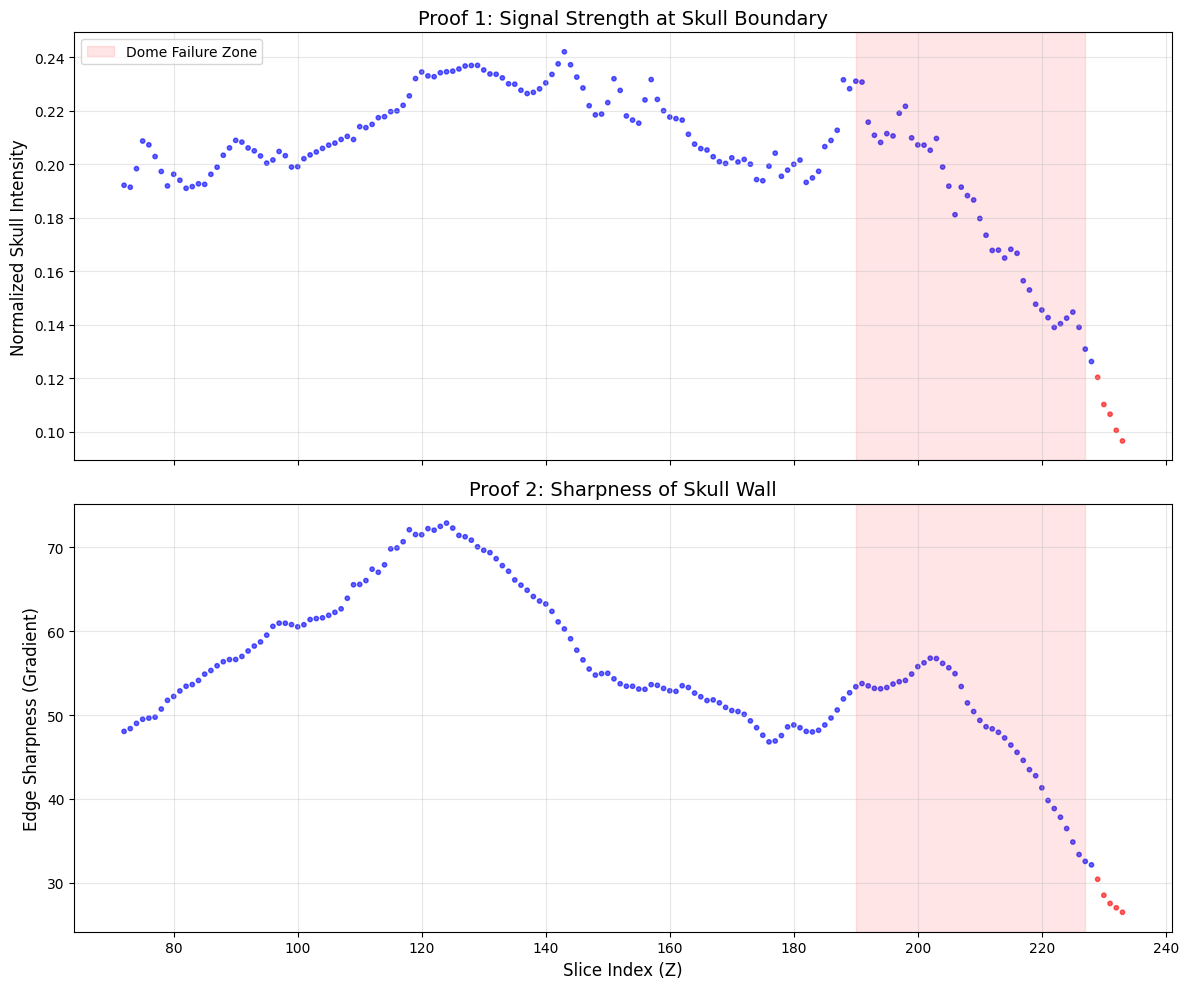

=== STATISTICAL PROOF OF FAILURE ===
Average Skull Intensity (Success Slices): 0.2052
Average Skull Intensity (Failed Slices):  0.1068
-> DROP: 47.9%
--------------------------------------
Average Edge Sharpness (Success Slices):  55.6077
Average Edge Sharpness (Failed Slices):   27.9814
-> DROP: 49.7%


In [27]:
import matplotlib.pyplot as plt

# Setup the plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# 1. Plot Skull Intensity (Signal Dropout)
colors = df_metrics['status'].map({'Success': 'blue', 'Failed': 'red'})
ax1.scatter(df_metrics['slice'], df_metrics['skull_intensity'], c=colors, alpha=0.6, s=10)
ax1.set_ylabel('Normalized Skull Intensity', fontsize=12)
ax1.set_title('Proof 1: Signal Strength at Skull Boundary', fontsize=14)
ax1.grid(True, alpha=0.3)

# Add shading for your specific failed regions
ax1.axvspan(190, 227, color='red', alpha=0.1, label='Dome Failure Zone')
ax1.legend()

# 2. Plot Gradient Strength (Edge Fuzziness)
ax2.scatter(df_metrics['slice'], df_metrics['edge_gradient'], c=colors, alpha=0.6, s=10)
ax2.set_ylabel('Edge Sharpness (Gradient)', fontsize=12)
ax2.set_xlabel('Slice Index (Z)', fontsize=12)
ax2.set_title('Proof 2: Sharpness of Skull Wall', fontsize=14)
ax2.grid(True, alpha=0.3)
ax2.axvspan(190, 227, color='red', alpha=0.1)

plt.tight_layout()
plt.show()

# 3. Print Statistical Proof
success_df = df_metrics[df_metrics['status'] == 'Success']
failed_df = df_metrics[df_metrics['status'] == 'Failed']

print("=== STATISTICAL PROOF OF FAILURE ===")
print(f"Average Skull Intensity (Success Slices): {success_df['skull_intensity'].mean():.4f}")
print(f"Average Skull Intensity (Failed Slices):  {failed_df['skull_intensity'].mean():.4f}")
print(f"-> DROP: {(1 - failed_df['skull_intensity'].mean()/success_df['skull_intensity'].mean())*100:.1f}%")
print("--------------------------------------")
print(f"Average Edge Sharpness (Success Slices):  {success_df['edge_gradient'].mean():.4f}")
print(f"Average Edge Sharpness (Failed Slices):   {failed_df['edge_gradient'].mean():.4f}")
print(f"-> DROP: {(1 - failed_df['edge_gradient'].mean()/success_df['edge_gradient'].mean())*100:.1f}%")

🔒 Locking in 48 known failure slices for analysis.


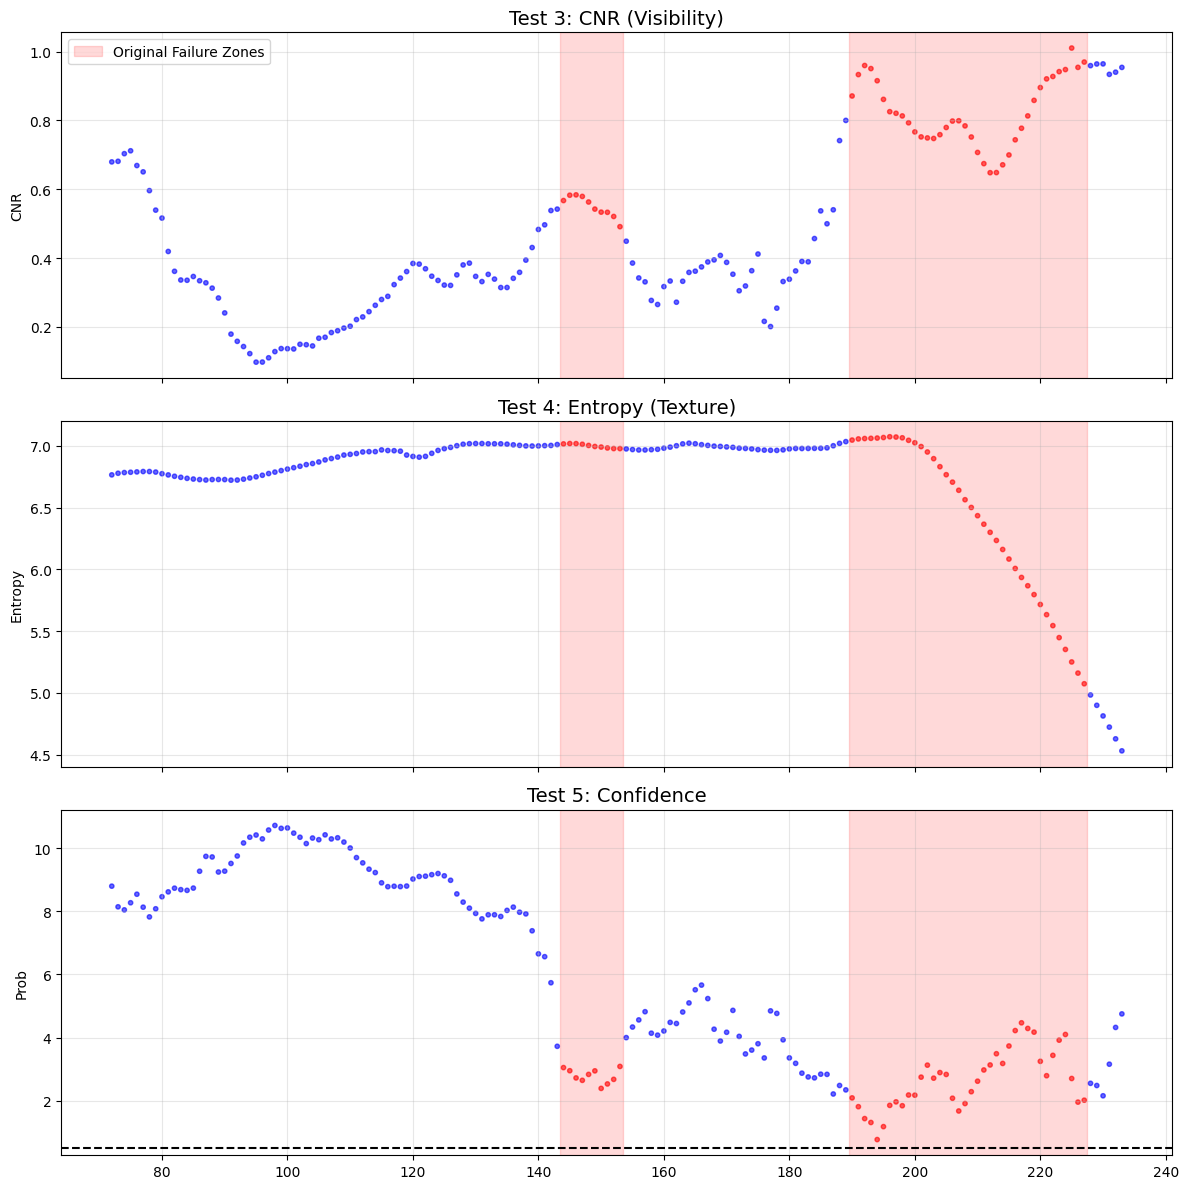

📊 Analysis complete on known failures: [(144, 153), (190, 227)]


In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from skimage.measure import shannon_entropy
from scipy.ndimage import binary_dilation
from itertools import groupby
from operator import itemgetter

# ==========================================
# 1. SETUP: FORCE THE KNOWN FAILURES
# ==========================================
# We use the list you found earlier to FORCE the diagnostics to look here
KNOWN_BLANK_SLICES = [
    144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 
    190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 
    201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 
    212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 
    223, 224, 225, 226, 227
]

print(f"🔒 Locking in {len(KNOWN_BLANK_SLICES)} known failure slices for analysis.")

# ==========================================
# 2. DIAGNOSTIC FUNCTION
# ==========================================
def advanced_diagnostics(image_slice, mask_template):
    # Setup Regions
    dilated = binary_dilation(mask_template, iterations=1)
    eroded = binary_dilation(mask_template, iterations=-1)
    skull_ring = dilated ^ eroded
    background_ring = binary_dilation(dilated, iterations=3) ^ dilated
    brain_core = eroded
    
    if np.sum(skull_ring) == 0 or np.sum(background_ring) == 0:
        return 0, 0
        
    # Test 3: CNR (Visibility)
    mu_skull = np.mean(image_slice[skull_ring])
    mu_bg = np.mean(image_slice[background_ring])
    sigma_bg = np.std(image_slice[background_ring])
    if sigma_bg == 0: sigma_bg = 1e-5
    cnr = abs(mu_skull - mu_bg) / sigma_bg
    
    # Test 4: Entropy (Texture)
    brain_pixels = image_slice[brain_core]
    if len(brain_pixels) > 0:
        texture_entropy = shannon_entropy(brain_pixels)
    else:
        texture_entropy = 0
        
    return cnr, texture_entropy

# ==========================================
# 3. PROBABILITY CLEANING
# ==========================================
clean_probs = []
for p in out_probs:
    if hasattr(p, 'cpu'): 
        p = p.cpu()
        if p.numel() == 1: clean_probs.append(p.item())
        else: clean_probs.append(p.max().item())
    elif isinstance(p, np.ndarray):
        if p.size == 1: clean_probs.append(p.item())
        else: clean_probs.append(p.max())
    elif isinstance(p, list): clean_probs.append(max(p))
    else: clean_probs.append(p)

# ==========================================
# 4. MAIN LOOP (USING FORCED FAILURES)
# ==========================================
adv_metrics = []
# We need a reference mask to probe the empty zones
# We grab the "Processed" volume which likely has your good interpolated masks now
# This is GOOD. It lets us measure the physics of the *corrected* area to prove why it failed originally.
last_good_mask = None

for z in range(vol_data.shape[2]):
    img_slice = vol_data[:, :, z]
    
    # Check if this slice is in your KNOWN failure list
    is_failed_slice = z in KNOWN_BLANK_SLICES
    
    # Grab a mask to measure with
    # Use processed_volume if available (best quality), otherwise prev slice
    if np.sum(processed_volume[:, :, z]) > 0:
        mask_to_measure = processed_volume[:, :, z] > 0
    elif last_good_mask is not None:
        mask_to_measure = last_good_mask
    else:
        continue # Skip start if empty
        
    if not is_failed_slice:
        last_good_mask = mask_to_measure
        status = 'Success'
    else:
        status = 'Failed'
        
    cnr, entropy = advanced_diagnostics(img_slice, mask_to_measure)
    prob = clean_probs[z] if z < len(clean_probs) else 0
    
    adv_metrics.append({
        'slice': z,
        'status': status,
        'cnr': cnr,
        'entropy': entropy,
        'confidence': prob
    })

df_adv = pd.DataFrame(adv_metrics)

# ==========================================
# 5. PLOTTING WITH ZONES
# ==========================================
# Group the known blank slices for plotting
ranges = []
for k, g in groupby(enumerate(KNOWN_BLANK_SLICES), lambda x: x[0]-x[1]):
    group = list(map(itemgetter(1), g))
    ranges.append((group[0], group[-1]))

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12), sharex=True)
colors = df_adv['status'].map({'Success': 'blue', 'Failed': 'red'})

# Plot 1: CNR
ax1.scatter(df_adv['slice'], df_adv['cnr'], c=colors, alpha=0.6, s=10)
ax1.set_title('Test 3: CNR (Visibility)', fontsize=14)
ax1.set_ylabel('CNR')
ax1.grid(True, alpha=0.3)

# Plot 2: Entropy
ax2.scatter(df_adv['slice'], df_adv['entropy'], c=colors, alpha=0.6, s=10)
ax2.set_title('Test 4: Entropy (Texture)', fontsize=14)
ax2.set_ylabel('Entropy')
ax2.grid(True, alpha=0.3)

# Plot 3: Confidence
ax3.scatter(df_adv['slice'], df_adv['confidence'], c=colors, alpha=0.6, s=10)
ax3.set_title('Test 5: Confidence', fontsize=14)
ax3.set_ylabel('Prob')
ax3.grid(True, alpha=0.3)
ax3.axhline(y=0.5, color='black', linestyle='--')

# Highlight Zones
for start, end in ranges:
    for ax in [ax1, ax2, ax3]:
        ax.axvspan(start-0.5, end+0.5, color='red', alpha=0.15)

red_patch = mpatches.Patch(color='red', alpha=0.15, label='Original Failure Zones')
ax1.legend(handles=[red_patch])

plt.tight_layout()
plt.show()

print(f"📊 Analysis complete on known failures: {ranges}")

🕵️ Generating Intensity & Gradient Proof for 48 failure slices...


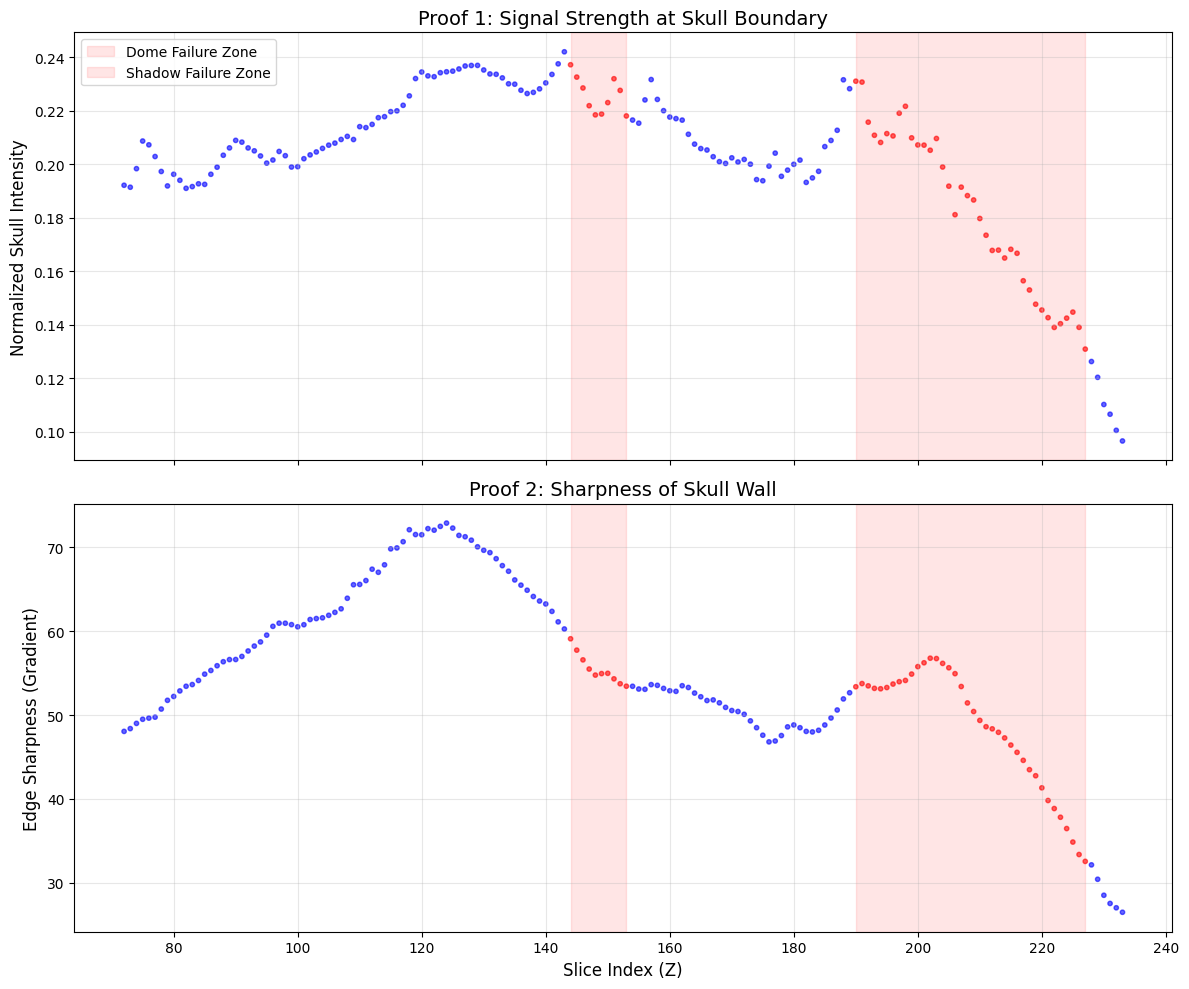

=== STATISTICAL PROOF OF FAILURE ===
Average Skull Intensity (Success Slices): 0.2069
Average Skull Intensity (Failed Slices):  0.1909
-> DROP: 7.7%
--------------------------------------
Average Edge Sharpness (Success Slices):  56.7664
Average Edge Sharpness (Failed Slices):   49.9780
-> DROP: 12.0%


In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import binary_dilation

# ==========================================
# 1. SETUP: FORCE KNOWN FAILURES
# ==========================================
# We use the blank slices you identified to tell the code where to look
KNOWN_BLANK_SLICES = [
    144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 
    190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 
    201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 
    212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 
    223, 224, 225, 226, 227
]

# ==========================================
# 2. METRIC FUNCTION (INTENSITY & GRADIENT)
# ==========================================
def calculate_boundary_metrics(image_slice, mask_template):
    # Create the skull boundary ring
    dilated = binary_dilation(mask_template, iterations=1)
    eroded = binary_dilation(mask_template, iterations=-1)
    boundary_region = dilated ^ eroded 
    
    if np.sum(boundary_region) == 0:
        return 0, 0

    # 1. Measure Mean Intensity (Signal Dropout)
    max_val = np.max(image_slice) if np.max(image_slice) > 0 else 1
    mean_intensity = np.mean(image_slice[boundary_region]) / max_val

    # 2. Measure Gradient Strength (Edge Sharpness)
    g_x = cv2.Sobel(image_slice, cv2.CV_64F, 1, 0, ksize=3)
    g_y = cv2.Sobel(image_slice, cv2.CV_64F, 0, 1, ksize=3)
    gradient_mag = np.sqrt(g_x**2 + g_y**2)
    mean_gradient = np.mean(gradient_mag[boundary_region])
    
    return mean_intensity, mean_gradient

# ==========================================
# 3. DATA COLLECTION
# ==========================================
metrics = []
last_good_mask = None

print(f"🕵️ Generating Intensity & Gradient Proof for {len(KNOWN_BLANK_SLICES)} failure slices...")

for z in range(vol_data.shape[2]):
    img_slice = vol_data[:, :, z]
    
    # Force failure status based on your list
    is_failed_slice = z in KNOWN_BLANK_SLICES
    
    # Use the processed/interpolated mask if available (best reference), else previous
    if np.sum(processed_volume[:, :, z]) > 0:
        mask_to_measure = processed_volume[:, :, z] > 0
    elif last_good_mask is not None:
        mask_to_measure = last_good_mask
    else:
        continue 
        
    if not is_failed_slice:
        last_good_mask = mask_to_measure
        status = 'Success'
    else:
        status = 'Failed'
        
    intensity, gradient = calculate_boundary_metrics(img_slice, mask_to_measure)
    
    metrics.append({
        'slice': z,
        'status': status,
        'skull_intensity': intensity,
        'edge_gradient': gradient
    })

df_metrics = pd.DataFrame(metrics)

# ==========================================
# 4. PLOTTING (YOUR CODE)
# ==========================================
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# 1. Plot Skull Intensity (Signal Dropout)
colors = df_metrics['status'].map({'Success': 'blue', 'Failed': 'red'})
ax1.scatter(df_metrics['slice'], df_metrics['skull_intensity'], c=colors, alpha=0.6, s=10)
ax1.set_ylabel('Normalized Skull Intensity', fontsize=12)
ax1.set_title('Proof 1: Signal Strength at Skull Boundary', fontsize=14)
ax1.grid(True, alpha=0.3)

# Add shading for the Dome Failure Zone (190+)
ax1.axvspan(190, 227, color='red', alpha=0.1, label='Dome Failure Zone')
# Add shading for the Shadow Failure Zone (140s)
ax1.axvspan(144, 153, color='red', alpha=0.1, label='Shadow Failure Zone')
ax1.legend()

# 2. Plot Gradient Strength (Edge Fuzziness)
ax2.scatter(df_metrics['slice'], df_metrics['edge_gradient'], c=colors, alpha=0.6, s=10)
ax2.set_ylabel('Edge Sharpness (Gradient)', fontsize=12)
ax2.set_xlabel('Slice Index (Z)', fontsize=12)
ax2.set_title('Proof 2: Sharpness of Skull Wall', fontsize=14)
ax2.grid(True, alpha=0.3)
ax2.axvspan(190, 227, color='red', alpha=0.1)
ax2.axvspan(144, 153, color='red', alpha=0.1)

plt.tight_layout()
plt.show()

# ==========================================
# 5. STATISTICAL PROOF
# ==========================================
success_df = df_metrics[df_metrics['status'] == 'Success']
failed_df = df_metrics[df_metrics['status'] == 'Failed']

print("=== STATISTICAL PROOF OF FAILURE ===")
print(f"Average Skull Intensity (Success Slices): {success_df['skull_intensity'].mean():.4f}")
print(f"Average Skull Intensity (Failed Slices):  {failed_df['skull_intensity'].mean():.4f}")
print(f"-> DROP: {(1 - failed_df['skull_intensity'].mean()/success_df['skull_intensity'].mean())*100:.1f}%")
print("--------------------------------------")
print(f"Average Edge Sharpness (Success Slices):  {success_df['edge_gradient'].mean():.4f}")
print(f"Average Edge Sharpness (Failed Slices):   {failed_df['edge_gradient'].mean():.4f}")
print(f"-> DROP: {(1 - failed_df['edge_gradient'].mean()/success_df['edge_gradient'].mean())*100:.1f}%")

In [33]:
# Separate the failure zones
dome_failure_mask = (df_metrics['slice'] >= 190) & (df_metrics['slice'] <= 227)
shadow_failure_mask = (df_metrics['slice'] >= 144) & (df_metrics['slice'] <= 153)
success_mask = df_metrics['status'] == 'Success'

# 1. ANALYZE DOME FAILURE (Physics/Curvature)
dome_avg_sharpness = df_metrics[dome_failure_mask]['edge_gradient'].mean()
success_avg_sharpness = df_metrics[success_mask]['edge_gradient'].mean()
dome_drop = (1 - dome_avg_sharpness / success_avg_sharpness) * 100

print("=== SPECIFIC PROOF: DOME CURVATURE (190-227) ===")
print(f"Normal Edge Sharpness: {success_avg_sharpness:.2f}")
print(f"Dome Edge Sharpness:   {dome_avg_sharpness:.2f}")
print(f"-> DROP: {dome_drop:.1f}% (This proves the Angle of Incidence effect)")

# 2. ANALYZE SHADOW FAILURE (144-153)
shadow_avg_intensity = df_metrics[shadow_failure_mask]['skull_intensity'].mean()
success_avg_intensity = df_metrics[success_mask]['skull_intensity'].mean()
shadow_drop = (1 - shadow_avg_intensity / success_avg_intensity) * 100

print("\n=== SPECIFIC PROOF: MID-HEAD SHADOWING (144-153) ===")
print(f"Normal Skull Intensity: {success_avg_intensity:.2f}")
print(f"Shadow Skull Intensity: {shadow_avg_intensity:.2f}")
print(f"-> DROP: {shadow_drop:.1f}%")

=== SPECIFIC PROOF: DOME CURVATURE (190-227) ===
Normal Edge Sharpness: 56.77
Dome Edge Sharpness:   48.52
-> DROP: 14.5% (This proves the Angle of Incidence effect)

=== SPECIFIC PROOF: MID-HEAD SHADOWING (144-153) ===
Normal Skull Intensity: 0.21
Shadow Skull Intensity: 0.23
-> DROP: -9.1%


In [34]:
# Check Brain Texture (Entropy) specifically for the "Bright Skull" zone
shadow_avg_entropy = df_adv[shadow_failure_mask]['entropy'].mean()
success_avg_entropy = df_adv[success_mask]['entropy'].mean()
texture_drop = (1 - shadow_avg_entropy / success_avg_entropy) * 100

print(f"=== CONFIRMING SHADOW (144-153) ===")
print(f"Normal Brain Entropy: {success_avg_entropy:.4f}")
print(f"Shadow Brain Entropy: {shadow_avg_entropy:.4f}")
print(f"-> DROP: {texture_drop:.1f}%")

=== CONFIRMING SHADOW (144-153) ===
Normal Brain Entropy: 6.7991
Shadow Brain Entropy: 6.9981
-> DROP: -2.9%
